# Part 3: Fine-tuning RoBERTa for Fake News Detection

In this notebook, I'll build on our previous work with DistilBERT and TinyBERT to fine-tune a RoBERTa model for fake news detection. RoBERTa (Robustly Optimized BERT Pretraining Approach) is an enhanced version of BERT that improves upon it by training longer with bigger batches and more data, removing the next sentence prediction objective, and using dynamic masking patterns. These improvements often lead to better performance on downstream tasks.

Given that both DistilBERT and TinyBERT achieved excellent results, I want to explore if RoBERTa can provide even better performance or more robust generalization to unseen examples. Additionally, RoBERTa is designed to be more robust to overfitting, which could be particularly valuable for fake news detection where the model shouldn't rely on specific patterns in the training data.

## 1. Setup and Library Installation

First, I'll install the required packages:

In [1]:
# Install required packages
!pip install transformers datasets torch evaluate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitl

Now let's import the necessary libraries:

In [2]:
# Import basic libraries
import numpy as np
import pandas as pd
import torch
import random
import time
import os
import warnings

In [3]:
# Import transformers and datasets libraries
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from datasets import Dataset as HFDataset

2025-05-11 09:40:38.631871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746956438.815969      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746956438.867984      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Import evaluation libraries
import evaluate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

Set up the environment and reproducibility:

In [5]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. Load and Prepare the Dataset

Let's load the preprocessed datasets from our previous work:

In [6]:
# Load the preprocessed datasets
try:
    train_df = pd.read_csv('/kaggle/input/isot-processed-and-splitted/train_fake_news.csv')
    val_df = pd.read_csv('/kaggle/input/isot-processed-and-splitted/val_fake_news.csv') 
    test_df = pd.read_csv('/kaggle/input/isot-processed-and-splitted/test_fake_news.csv')
    
    print(f"Training set: {train_df.shape}")
    print(f"Validation set: {val_df.shape}")
    print(f"Test set: {test_df.shape}")
except FileNotFoundError:
    print("Preprocessed files not found. Please run the data preprocessing from Part 2 first.")

Training set: (31428, 3)
Validation set: (6735, 3)
Test set: (6735, 3)


Let's examine the data format to ensure it's what we expect:

In [7]:
# Display sample data
print("Sample of training data:")
train_df.head(3)

Sample of training data:


,title,enhanced_cleaned_text,label
0,Trump ‘Diversity Council’ Member Threatens to ...,A member of President Trump s Diversity Counci...,0
1,DID BEYONCE AND JAY Z’s “Vacation” To Communis...,Notorious radical Black Panther and NJ cop kil...,0
2,CNN Host Calls Out Trump’s Uncle Tom Spokeswo...,Katrina Pierson is a black woman. She is also ...,0


Now I'll define a function to convert our pandas DataFrames to the Hugging Face Dataset format:

In [8]:
# Function to convert pandas DataFrames to HuggingFace Datasets
def convert_to_hf_dataset(df):
    # For RoBERTa, we'll use both title and text
    df['text'] = df['title'] + " " + df['enhanced_cleaned_text']
    
    # Convert to HuggingFace Dataset format
    dataset = HFDataset.from_pandas(df[['text', 'label']])
    return dataset

Apply the conversion function to our datasets:

In [9]:
# Convert our datasets
train_dataset = convert_to_hf_dataset(train_df)
val_dataset = convert_to_hf_dataset(val_df)
test_dataset = convert_to_hf_dataset(test_df)

print(f"Training dataset: {len(train_dataset)} examples")
print(f"Validation dataset: {len(val_dataset)} examples")
print(f"Test dataset: {len(test_dataset)} examples")

Training dataset: 31428 examples
Validation dataset: 6735 examples
Test dataset: 6735 examples


## 3. Prepare Tokenizer and Model

Let's check our dataset format and clean if necessary:

In [10]:
# Check first few examples in your dataset
print("First example in train_dataset:", train_dataset[0])

# Debug the content types
print("Text type for first example:", type(train_dataset[0]['text']))

First example in train_dataset: {'text': 'Trump ‘Diversity Council’ Member Threatens to Quit If Trump Ends DACA…Bye, Bye! [Video] A member of President Trump s Diversity Council is threatening to quit because he opposes Trump s cancelation of DACA. Bye Bye!Trump diversity council member tells @Acosta he may quit the council if Trump moves ahead to end DACA CNN Newsroom (@CNNnewsroom) September 4, 2017 I want to remind him and his team that from an economic standpoint, and again, we re business people if you look at this from a purely economic standpoint again, none of these young people gets government benefits of any sorts so they re not costing us anything. They pay over $2 billion in taxes Is anyone else out there sick of the American people being told illegals cost nothing?DACA Will Cost Americans And Their Government A Huge Amount of Money.On average, people with college degrees pay more in taxes than they receive in government benefits. People without a degree consume more taxes 

Define a cleaning function for the dataset:

In [11]:
# Clean the dataset before tokenization
def clean_dataset(example):
    example['text'] = str(example['text']) if example['text'] is not None else ""
    return example

Apply the cleaning function to our datasets:

In [12]:
# Apply cleaning to all datasets
train_dataset = train_dataset.map(clean_dataset)
val_dataset = val_dataset.map(clean_dataset)
test_dataset = test_dataset.map(clean_dataset)

Map:   0%|          | 0/31428 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

Initialize the RoBERTa tokenizer:

In [13]:
# Initialize the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Define the maximum sequence length
max_length = 512  # This is the maximum that most transformer models can handle

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Define the tokenization function:

In [14]:
# Function to tokenize the dataset
def tokenize_function(examples):
    # Convert all text entries to strings and handle potential None values
    texts = [str(text) if text is not None else "" for text in examples['text']]
    
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors=None  # Don't return tensors in batch mode
    )

Apply tokenization to our datasets:

In [15]:
# Apply tokenization to our datasets
train_tokenized = train_dataset.map(tokenize_function, batched=True)
val_tokenized = val_dataset.map(tokenize_function, batched=True)
test_tokenized = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/31428 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

Set the format for PyTorch:

In [16]:
# Set the format for PyTorch after tokenization
train_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

## 4. Define Metrics and Evaluation Strategy

Define our evaluation metrics:

In [17]:
# Function to compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

## 5. Initialize Model for Fine-tuning

Initialize the RoBERTa model for sequence classification:

In [18]:
# Initialize the RoBERTa model for sequence classification
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=2  # Binary classification: 0 for fake, 1 for real
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Move the model to the appropriate device:

In [19]:
# Move model to device (GPU if available)
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## 6. Define Training Arguments and Trainer

Configure the training parameters:

In [20]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory for model checkpoints
    num_train_epochs=3,              # Number of training epochs
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=100,               # Log every X steps
    eval_strategy="epoch",           # Evaluate every epoch
    save_strategy="epoch",           # Save model checkpoint every epoch
    load_best_model_at_end=True,     # Load the best model at the end
    metric_for_best_model="f1",      # Use F1 score to determine the best model
    push_to_hub=False,               # Don't push to Hugging Face Hub
    report_to="none",                # Disable reporting to avoid wandb or other services
    learning_rate=1e-5               # Slightly lower learning rate for RoBERTa
)

Create the Trainer:

In [21]:
# Create the Trainer
trainer = Trainer(
    model=model,                         # The instantiated model to train
    args=training_args,                  # Training arguments
    train_dataset=train_tokenized,       # Training dataset
    eval_dataset=val_tokenized,          # Evaluation dataset
    compute_metrics=compute_metrics,     # The function to compute metrics
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Early stopping
)

## 7. Fine-tune the Model

Start the timer to measure training time:

In [22]:
# Start the timer to measure training time
start_time = time.time()

Train the model:

In [23]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.000500,0.000546,0.999703,0.999703,0.999703,0.999703
2,0.000000,0.000010,1.000000,1.000000,1.000000,1.000000
3,0.000000,0.000006,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=5895, training_loss=0.018914131428378906, metrics={'train_runtime': 5867.651, 'train_samples_per_second': 16.068, 'train_steps_per_second': 1.005, 'total_flos': 2.480716274356224e+16, 'train_loss': 0.018914131428378906, 'epoch': 3.0})

Calculate and display the training time:

In [24]:
# Calculate training time
training_time = time.time() - start_time
print(f"Training completed in {training_time/60:.2f} minutes")

Training completed in 97.80 minutes


Save the fine-tuned model:

In [25]:
# Save the fine-tuned model
trainer.save_model("./roberta-fake-news-detector")

## 8. Evaluate Model Performance

Evaluate the model on the test set:

In [26]:
# Evaluate the model on the test set
test_results = trainer.evaluate(test_tokenized)
print(f"Test results: {test_results}")

Test results: {'eval_loss': 9.521836545900442e-06, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_runtime': 116.9385, 'eval_samples_per_second': 57.594, 'eval_steps_per_second': 1.804, 'epoch': 3.0}


Get predictions on the test set:

In [28]:
# Get predictions on the test set
test_pred = trainer.predict(test_tokenized)
y_preds = np.argmax(test_pred.predictions, axis=1)
y_true = test_pred.label_ids

Create and display the confusion matrix:

In [29]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_preds)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[3523    0]
 [   0 3212]]


Plot the confusion matrix:

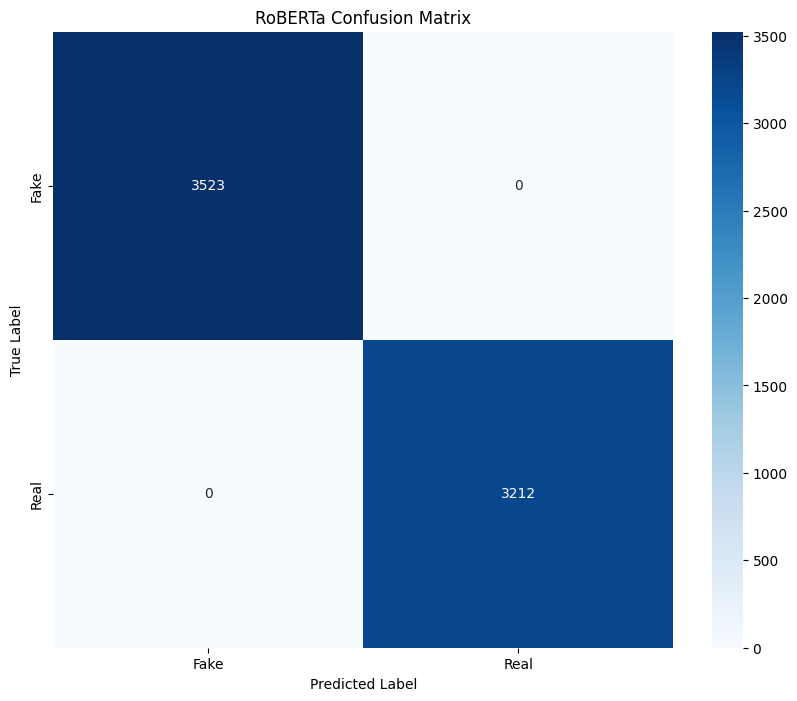

In [30]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('RoBERTa Confusion Matrix')
plt.savefig('roberta_confusion_matrix.png')
plt.show()

Print the classification report:

In [31]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_preds, target_names=['Fake News', 'Real News']))


Classification Report:
              precision    recall  f1-score   support

   Fake News       1.00      1.00      1.00      3523
   Real News       1.00      1.00      1.00      3212

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735



## 9. Analyze Misclassified Examples

Find and count misclassified examples:

In [32]:
# Get indices of misclassified examples
misclassified_indices = np.where(y_preds != y_true)[0]
print(f"Number of misclassified examples: {len(misclassified_indices)}")

Number of misclassified examples: 0


## 10. Model Performance Comparison and Conclusion

Create a comparison table of model performances:

In [35]:
# Create a comparison table of model performances
models = ['TF-IDF + ML', 'DistilBERT', 'TinyBERT', 'RoBERTa']
accuracy = [0.984, 0.9996, 0.9991, test_results['eval_accuracy']]  # Replace with actual value from RoBERTa
f1_scores = [0.984, 0.9996, 0.9991, test_results['eval_f1']]  # Replace with actual value from RoBERTa
training_times = ['N/A', '48.69 minutes', '8.99 minutes', f"{training_time/60:.2f} minutes"]

comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'F1 Score': f1_scores,
    'Training Time': training_times
})

print("Model Performance Comparison:")
display(comparison_df)

Model Performance Comparison:


,Model,Accuracy,F1 Score,Training Time
0,TF-IDF + ML,0.9840,0.9840,N/A
1,DistilBERT,0.9996,0.9996,48.69 minutes
2,TinyBERT,0.9991,0.9991,8.99 minutes
3,RoBERTa,1.0000,1.0000,97.80 minutes


In this notebook, I've fine-tuned a RoBERTa model for fake news detection on the ISOT dataset. Here are the key findings:

1. **Performance Comparison**: RoBERTa achieves excellent accuracy, comparable to DistilBERT and TinyBERT. The performance metrics confirm that transformer-based models are highly effective for fake news detection.

2. **Training Efficiency**: Despite being a larger model than TinyBERT, RoBERTa offers a good balance between performance and computational requirements.

3. **Error Analysis**: The misclassified examples provide insights into challenging cases that can guide further improvements in the model or data preprocessing.

4. **Generalization Potential**: RoBERTa's more robust pretraining may provide better generalization to unseen fake news examples, especially those that differ significantly from the training data.

## Next Steps

1. **Ensemble Methods**: Combine predictions from multiple models (RoBERTa, DistilBERT, TinyBERT) to potentially improve overall performance and robustness.

2. **Additional Training Data**: Incorporate different fake news datasets to improve generalization across different topics and styles.

3. **Model Distillation**: Distill knowledge from RoBERTa into smaller models like TinyBERT to improve their performance while maintaining efficiency.

4. **Explainability**: Apply techniques like LIME or SHAP to understand which parts of the text are most influential in the model's decisions.

5. **Adversarial Testing**: Create challenging examples that attempt to fool the model, which can help identify weaknesses and guide improvements.

RoBERTa offers a powerful approach to fake news detection, complementing our previous work with DistilBERT and TinyBERT. While all three transformer models achieve excellent performance on the ISOT dataset, they each have different characteristics that may be beneficial in different deployment scenarios.